In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import load_mnist

In [2]:
(m_x_train, m_t_train), (m_x_val, m_t_val), num_cls = load_mnist(final=False)
(full_m_x_train, full_m_t_train), (m_x_test, m_t_test), num_cls = load_mnist(final=True)

In [3]:
# utils
def n_sigmoid(x):
    return 1 / (1 + (np.exp(-x)))

def n_softmax(x):
    # stabilize by substracting the max
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def n_d_sigmoid(x):
    s = n_sigmoid(x)
    return s * (1 - s)

def lin(input, weight, bias):
    return np.dot(input, weight) + bias

def lin_grad(lin_input, output_grad, weights):
    dW = np.matmul(lin_input.reshape(lin_input.shape[0], 1), output_grad.reshape(1, output_grad.shape[0]))
    dx = (output_grad[None, :] * weights).sum(axis=1)
    db = output_grad.copy()
    return dW, dx, db

def n_cross_entropy(predictions, targets):
    # target is one hot
    return -np.sum(targets * np.log(predictions))

# minmax scaler
def n_normalize(v, ma, mi): 
    norm = (v - mi) / (ma - mi)
    return norm

def n_one_hot(arr):
    new_arr = np.zeros((arr.size, arr.max() + 1))
    new_arr[np.arange(arr.size), arr] = 1
    return new_arr

def one_hot(i, size):
    oh = np.zeros(size)
    oh[i] = 1
    return oh

In [4]:
ma = m_x_train.max()
mi = m_x_train.min()

m_x_train_normize = n_normalize(m_x_train, ma, mi)
m_t_train_one_hot = n_one_hot(np.array(m_t_train))

m_x_val_normize = n_normalize(m_x_val, ma, mi)
m_t_val_one_hot = n_one_hot(np.array(m_t_val))

m_x_test_normize = n_normalize(m_x_test, ma, mi)
m_t_test_one_hot = n_one_hot(np.array(m_t_test))

In [5]:
def plot_all(epochs, train_losses, val_losses, train_std, val_stds, accuracies):
    t = np.arange(epochs)
    
    plt.plot(t, train_losses, 'b', label='Training Loss')
    plt.plot(t, val_losses, 'g', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(t, train_std, 'b', label='Training Standard Deviation')
    plt.plot(t, val_stds, 'g', label='Validation Standard Deviation')
    plt.title('Standard Deviation')
    plt.xlabel('Epochs')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.show()
    
    plt.plot(t, accuracies, 'g', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
def model(epoch, lr):
    # hyperparameters
    lr = 1e-5
    size_layer_1 = 300
    size_layer_2 = 10

    num_of_input = 784
    W = np.random.randn(num_of_input, size_layer_1) 
    b = np.zeros(size_layer_1)

    V = np.random.randn(size_layer_1, size_layer_2) 
    c = np.zeros(size_layer_2)

    len_train =  len(m_x_train_normize)
    losses = []
    val_losses = []
    accuracies = []
    stds = []
    val_stds = []

    # training loop
    for e in range(epoch):
        a_dW = np.zeros((num_of_input, size_layer_1))
        a_dV = np.zeros((size_layer_1, size_layer_2))
        a_db = np.zeros(size_layer_1)
        a_dc = np.zeros(size_layer_2)
        
        loss = []
        
        for i in range(len_train):
            
            x = m_x_train_normize[i]
            t = m_t_train_one_hot[i]
            
            # forward
            # y, h, k = forward(x, W, b, V, c)
            k = lin(x, W, b)
            h = n_sigmoid(k)
            o = lin(h, V, c)
            y = n_softmax(o)
            
            l = n_cross_entropy(y, t)
            loss.append(l)
            
            # backward
            # dV, dc, dW, db = backward(y, t, h, V, k, x, W)
            do = y - t 
            dV, dh, dc = lin_grad(h, do, V)
            dk = dh * n_d_sigmoid(k)
            dW, dx, db = lin_grad(x, dk, W)
            
            # accumulate gradients
            a_dW += dW
            a_dV += dV
            a_db += db
            a_dc += dc
        
        # sgd - after each epoch
        W = W + -lr * a_dW
        b = b + -lr * a_db
        V = V + -lr * a_dV
        c = c + -lr * a_dc
        
        mean_loss = np.mean(loss)
        losses.append(mean_loss)
        std = np.std(loss)
        stds.append(std)
        
        # test on validation set
        len_val =  len(m_x_val_normize)
        correct = 0
        
        val_loss = []
        for i in range(len_val):
            x = m_x_val_normize[i]
            t = m_t_val_one_hot[i]

            k = lin(x, W, b)
            h = n_sigmoid(k)
            o = lin(h, V, c)
            y = n_softmax(o)
            
            l = n_cross_entropy(y, t)
            val_loss.append(l)
            
            if y.argmax() == t.argmax():
                correct += 1
                
        val_mean_loss = np.mean(val_loss)
        val_losses.append(val_mean_loss)
        val_std = np.std(val_loss)
        val_stds.append(val_std)
        
        acc = correct/len_val
        accuracies.append(acc)
        
        print(f'Accuracy: {(acc) * 100}%')
        print(f'STD: {(std)}')
        print(f'Mean loss: {(mean_loss)}')
        
        print(f'Done epoch : {e+1}')
    
    print('LOSSES: ', losses)
    print('ACCURACIES: ', accuracies)
    print('VALIDATION LOSSES: ', val_losses)
    print('STD', stds)
    print('VALIDATION STD', val_stds)
    
    plot_all(epoch, losses, val_losses, stds, val_stds, accuracies)
    
    
    
    return W, b, V, c
    

Accuracy: 13.68%
STD: 14.821814806787875
Mean loss: 23.911658150751624
Done epoch : 1
Accuracy: 13.200000000000001%
STD: 13.087139704743514
Mean loss: 16.083832380445937
Done epoch : 2
LOSSES:  [23.911658150751624, 16.083832380445937]
ACCURACIES:  [0.1368, 0.132]
VALIDATION LOSSES:  [16.03397594522069, 12.185864264132636]
STD [14.821814806787875, 13.087139704743514]
VALIDATION STD [13.05570558728444, 9.798125347331212]


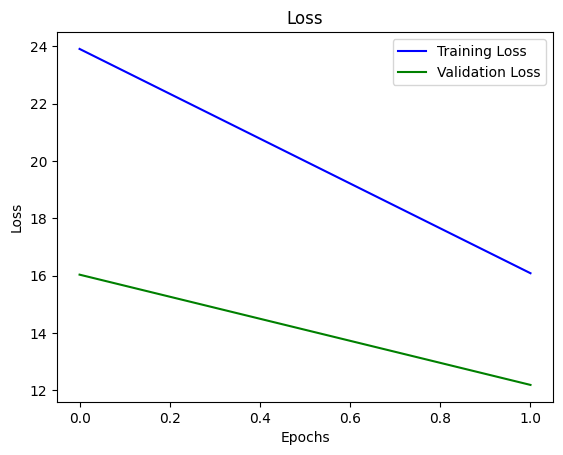

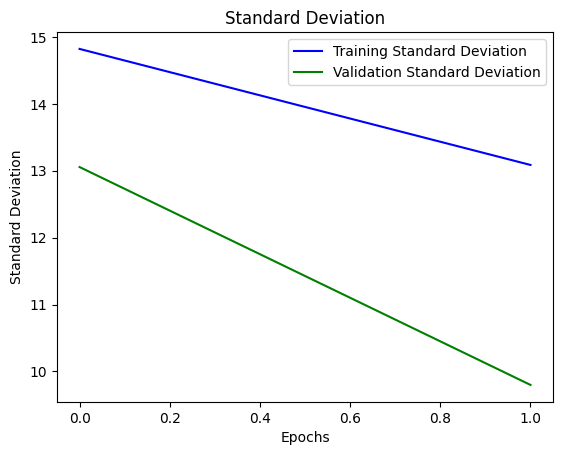

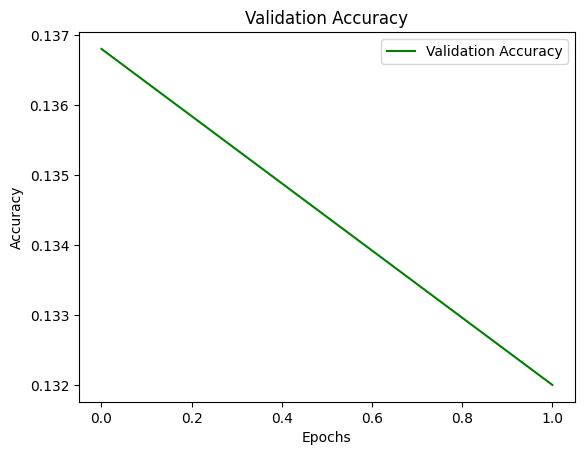

(array([[-0.25177111,  0.6764263 ,  1.03241655, ...,  0.62659583,
          0.33362587, -0.47856356],
        [ 0.89287553, -1.31270907,  0.35846113, ...,  1.16539149,
         -0.33106776, -1.98713796],
        [-1.73577563, -0.19226141,  0.38342377, ...,  0.30180566,
          3.7934315 , -0.87297911],
        ...,
        [ 0.28313524,  0.70622184,  1.51641106, ...,  1.52228777,
         -0.73502154, -0.70718624],
        [ 0.66917395, -1.55547222,  0.33463461, ...,  0.27020808,
         -0.0778372 ,  0.17851326],
        [-0.42791661, -0.97293367,  0.11410287, ..., -0.21397101,
          1.78260504,  1.10344317]]),
 array([-1.98856201e-02,  1.42769834e-02, -6.86748609e-03, -7.13650728e-03,
        -1.92392606e-03,  1.51593652e-02, -1.10840964e-02,  4.18494564e-03,
        -7.10621648e-03, -8.40617728e-02, -4.81575795e-02,  3.52144561e-02,
         2.65865441e-02, -8.14622633e-03,  3.68701412e-03, -3.12503456e-02,
         8.01026996e-03,  5.65439114e-03,  3.97253938e-03,  1.2286264

In [7]:
model(2, 1e-5)

In [ ]:
# PRE BATCH
# X: [0.72403035 0.57477459]
# T: [1 0]
# K: [ 0.36209824  1.54471427 -3.05815947]
# H: [0.58954826 0.824149   0.04486651]
# O: [-1.53556632  0.50186643]
# Y: [0.1153284 0.8846716]
# L: 2.1599715319834916
# do: [-0.8846716  0.8846716]
# dV: [[-0.5215566   0.5215566 ]
#  [-0.72910121  0.72910121]
#  [-0.03969213  0.03969213]]
# dh: [ 0.82192034  1.65830888 -1.08759122]
# dc: [-0.8846716  0.8846716]
# dk: [ 0.19888919  0.24033444 -0.0466071 ]
# dW: [[ 0.14400181  0.17400943 -0.03374495]
#  [ 0.11431646  0.13813813 -0.02678858]]
# dx: [0.4507357  0.45139621]
# db: [ 0.19888919  0.24033444 -0.0466071 ]
# Done epoch : 1

#  for i in range(0, len_train, batch_size):
#         # in1, in2 = norm_train_x[i:i+batch_size]
#         batch = norm_train_x[i:i+batch_size]
#         print(f'BATCH: {batch}')
#         out = 0 if norm_train_y[i] == 1 else 1 
#         t = np.array(target_arr(num_cls, out))
#         # x = np.array([in1, in2])
#         x = batch

# X: [ 1 -1]
# T: [ 1 -1]
# K: [2. 2. 2.]
# H: [0.88079708 0.88079708 0.88079708]
# O: [-0.88079708 -0.88079708]
# Y: [0.5 0.5]
# L: 0.6931471805599453
# do: [ 0.5 -0.5]
# dV: [[ 0.44039854 -0.44039854]
#  [ 0.44039854 -0.44039854]
#  [ 0.44039854 -0.44039854]]
# dh: [0. 0. 0.]
# dc: [ 0.5 -0.5]
# dk: [0. 0. 0.]
# dW: [[0. 0. 0.]
#  [0. 0. 0.]]
# dx: [0. 0.]
# db: [0. 0. 0.]
# Done epoch : 1